Load dataset and examine basic structure and stats

In [25]:
import pandas as pd

df = pd.read_csv('../data/auto-mpg.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    int64  
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car_name      392 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 27.7+ KB


Let's check for any null/empty rows, entries or columns.

In [26]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

Our mpg column, which is our label column, is usually a continuous value; the values have already been converted into a binary format to be used for this classification task via manual thresholding (-1 if mpg < 23, 1 otherwise). So now we'll check the class balance. 

In [27]:
df['mpg'].value_counts()

mpg
-1    196
 1    196
Name: count, dtype: int64

We have a perfect 50/50 proportion of positive and negative classes which is ideal as our model needs to be able to perform well on all classes provided in the data, rather than being better at classifying one task.

Now we need to visualize the different features in the dataset to observe their distributions and identify any issues. We will observe their distributions using histograms.


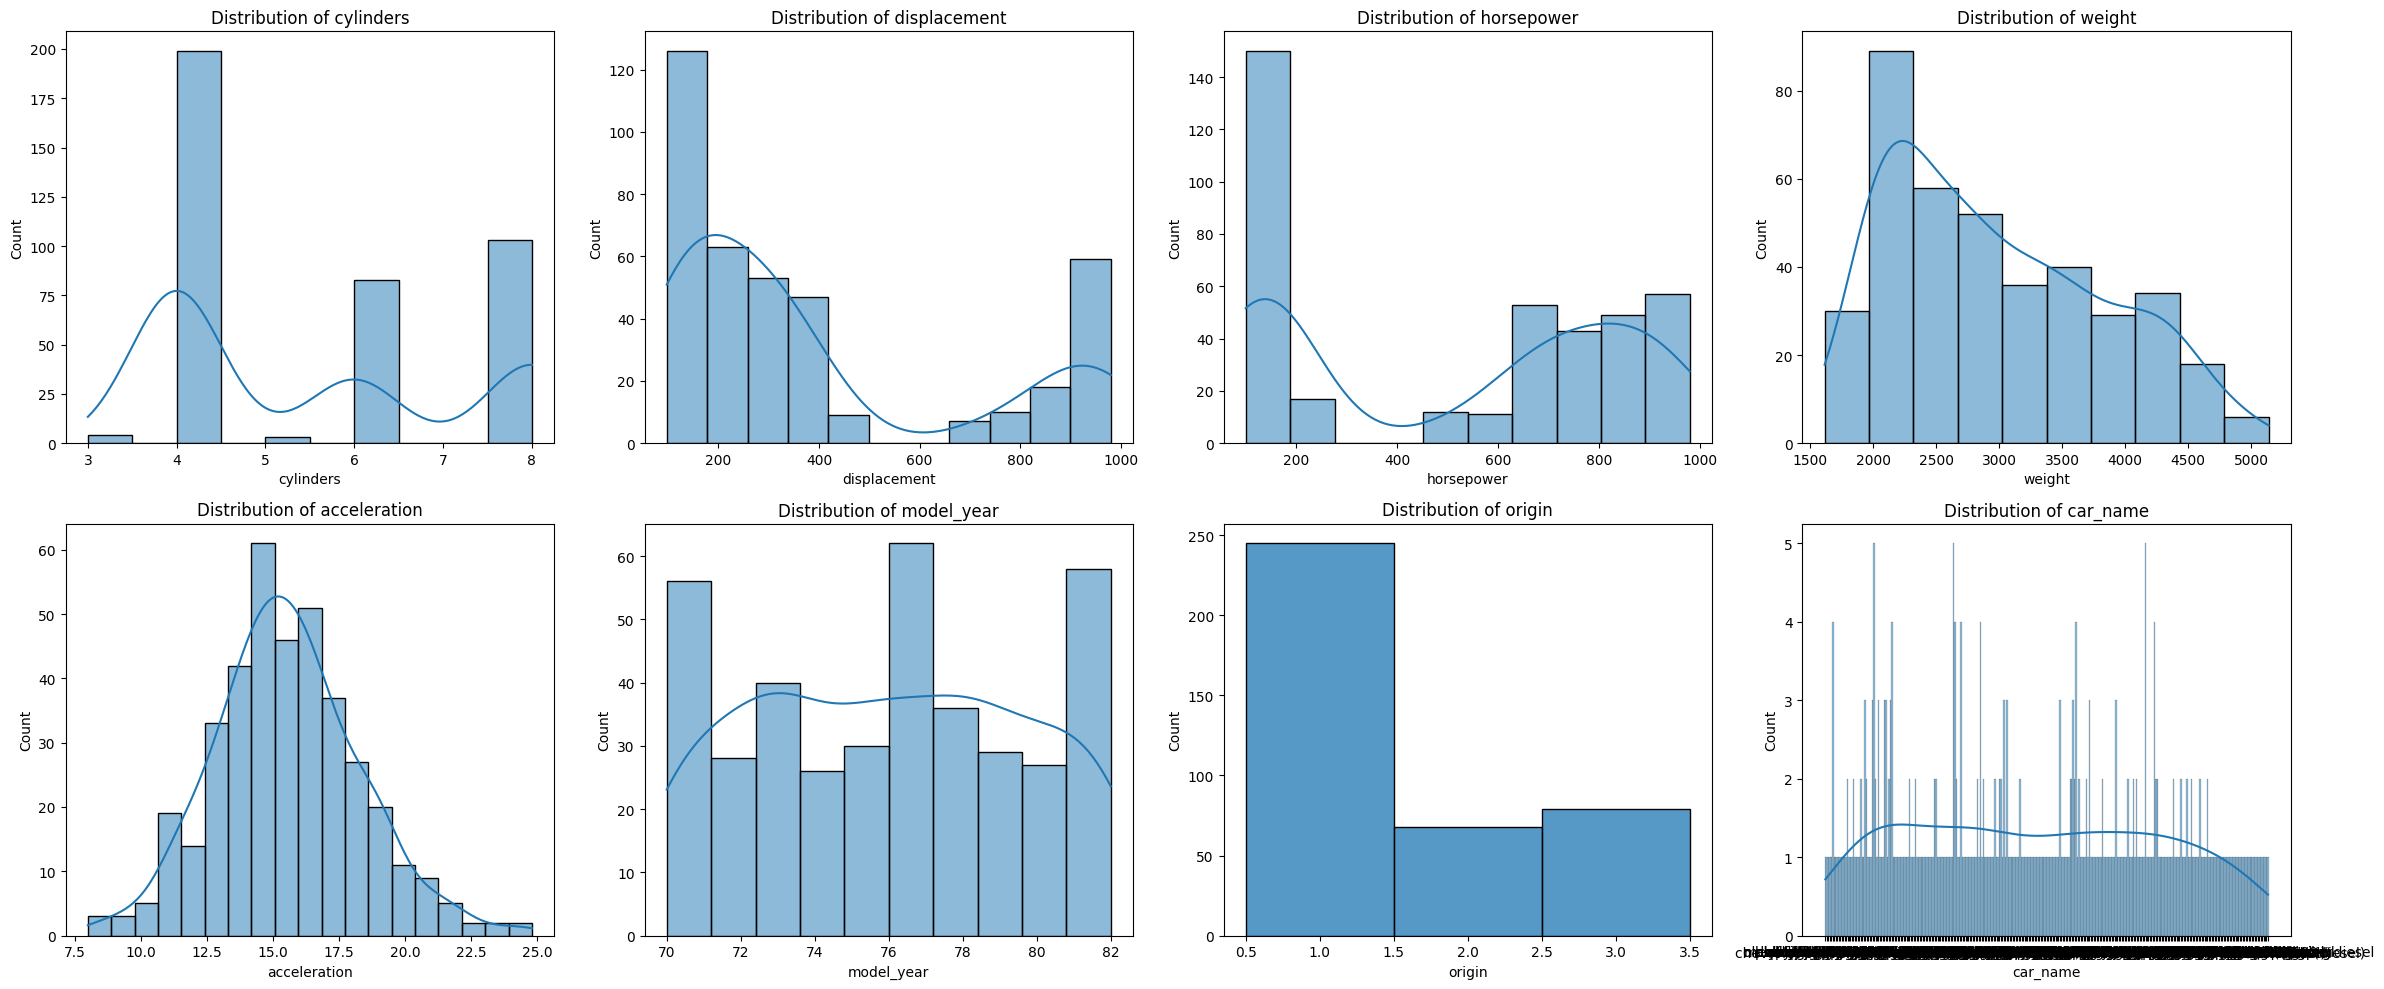

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [col for col in df.columns if col not in ['mpg', 'car_make']]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 10))

for i, feature in enumerate(features):
    ax = axes[i // 4, i % 4]
    if df[feature].nunique() < 5:
        sns.histplot(df[feature], discrete=True, ax=ax)
    else:
        sns.histplot(df[feature], kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    
plt.tight_layout()

Majority of the features reflect real world distributions, i.e. lower numbers of cylinders and less horsepower are more common in cars. There is usually 1 car per name, so using the make + model name will be unnecessary. An idea is to check distributions of just car make to decide whether that is a better feature to use.

We'll also look at correlations between features and mgp class to use the features with the strongest correlation in our model.

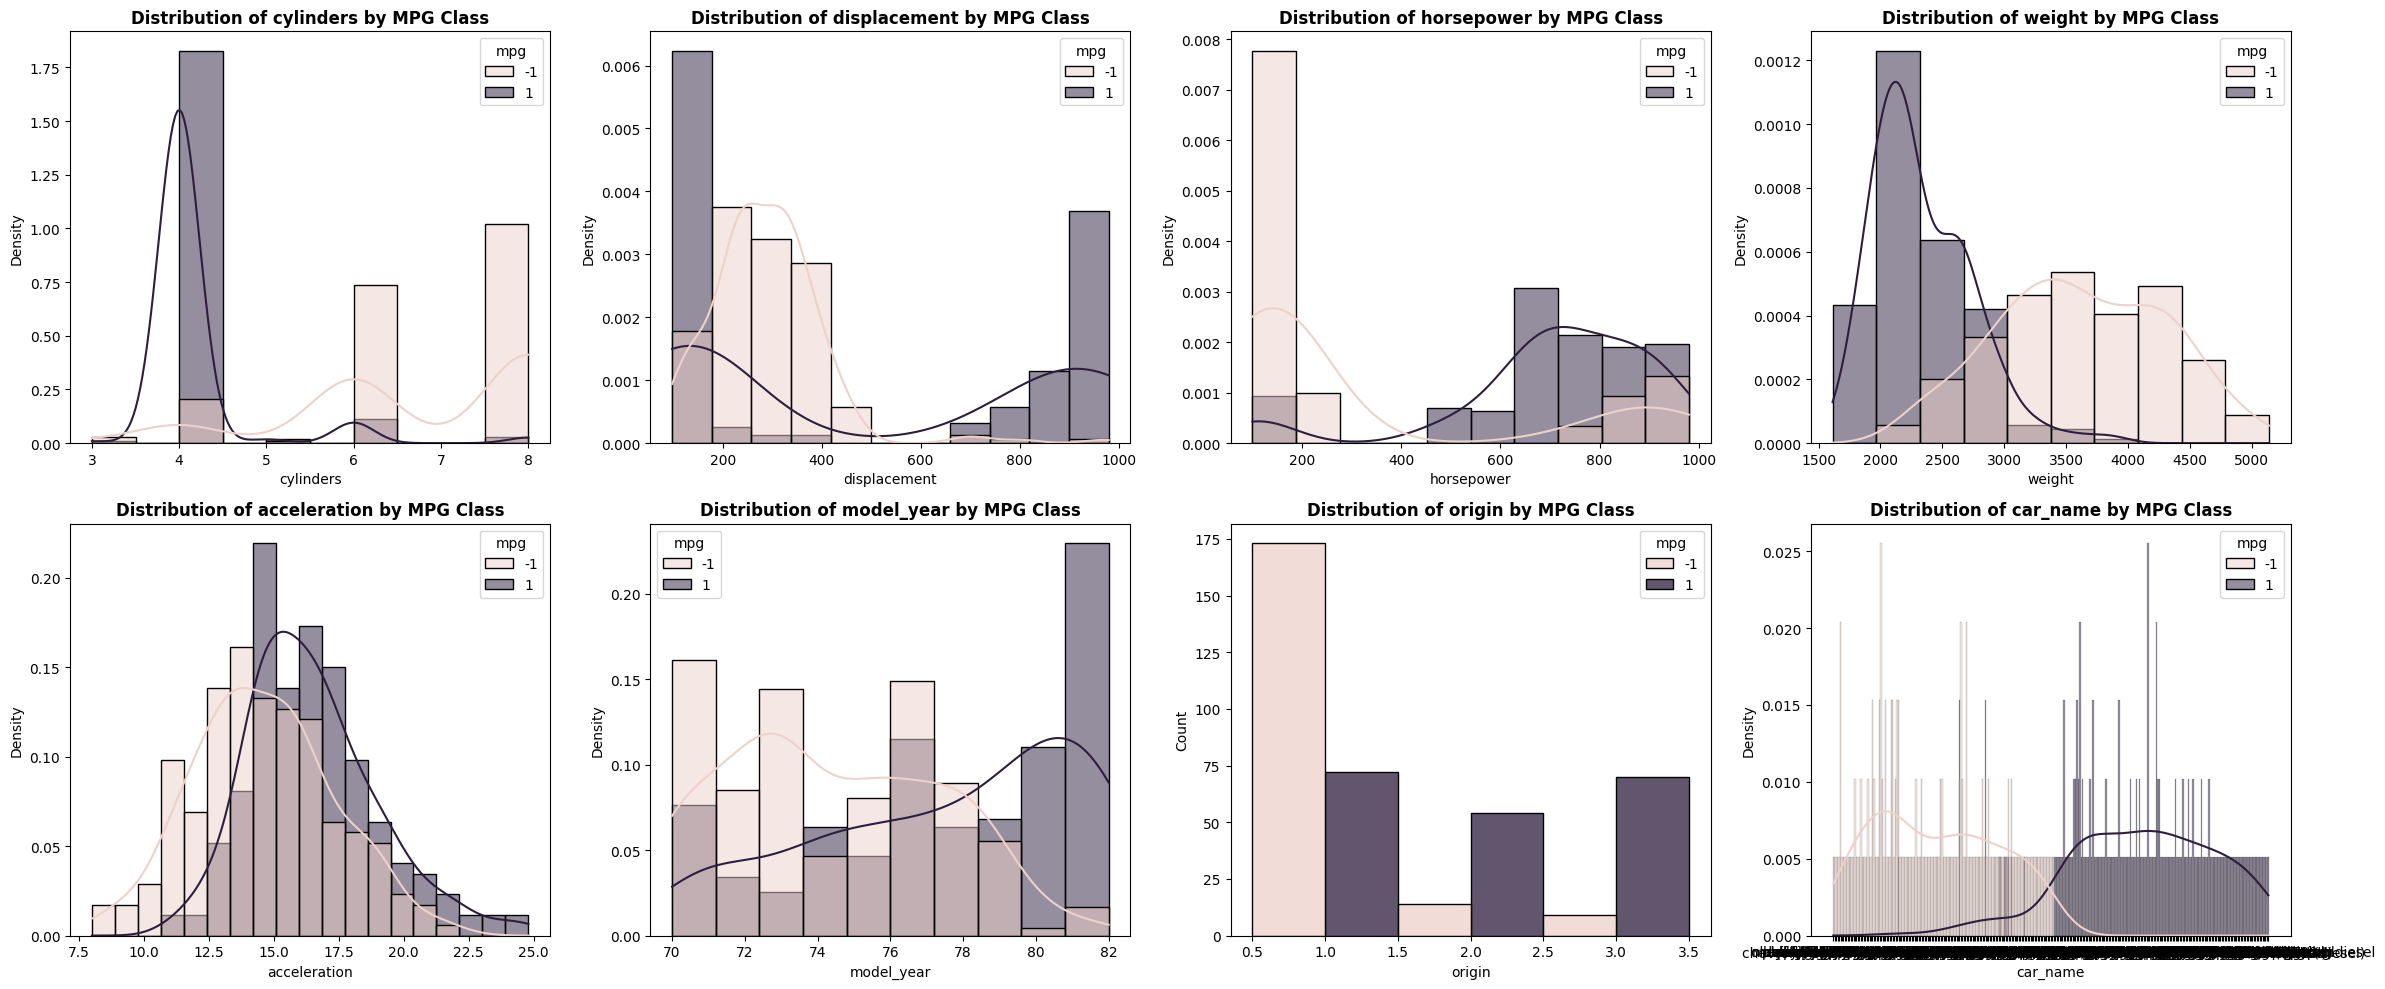

In [63]:
features = [col for col in df.columns if col not in ['mpg', 'car_make']]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 10))

for i, feature in enumerate(features):
    ax = axes[i // 4, i % 4]
    if df[feature].nunique() < 5:
        sns.histplot(data=df, x=feature, hue='mpg', multiple='dodge', discrete=True, ax=ax)
    else:
        sns.histplot(data=df, x=feature, hue='mpg', kde=True, stat='density', common_norm=False, ax=ax)
    ax.set_title(f"Distribution of {feature} by MPG Class", fontweight='bold')
    
plt.tight_layout()

From these we can say that there are observable correlations between mpg and: cylinder count, horsepower, weight and model year. For acceleration, there is no correlation. For displacement and country of origin the correlation is a little less clear and so the linear model may struggle, for the former, we may need to see if this behaviour has any connection to other features.

Let's also do the same for car make, we'll create a new column in the dataset for this. 

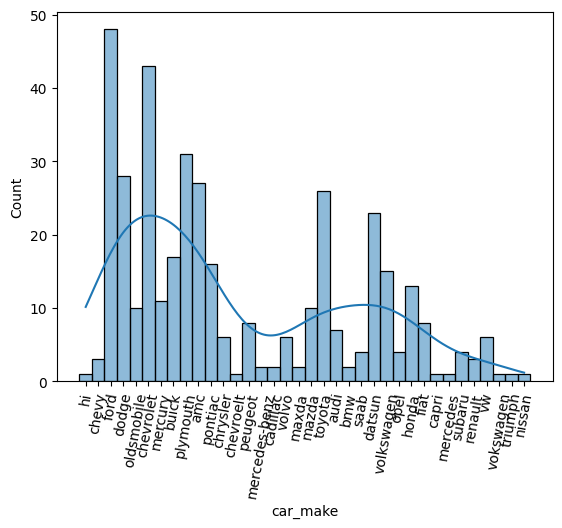

In [40]:
df['car_make'] = df['car_name'].str.split().str[0].str.lower()

sns.histplot(data=df, x ='car_make', kde=True)
plt.xticks(rotation=80);

There's a lot of different car makes with varying frequencies. Therefore, it is worth potentially omitting this feature from model training if it doesn't contribute to its performance.

Now let's create some box plots to aid in seeing how different features are distributed across our two mpg classes.

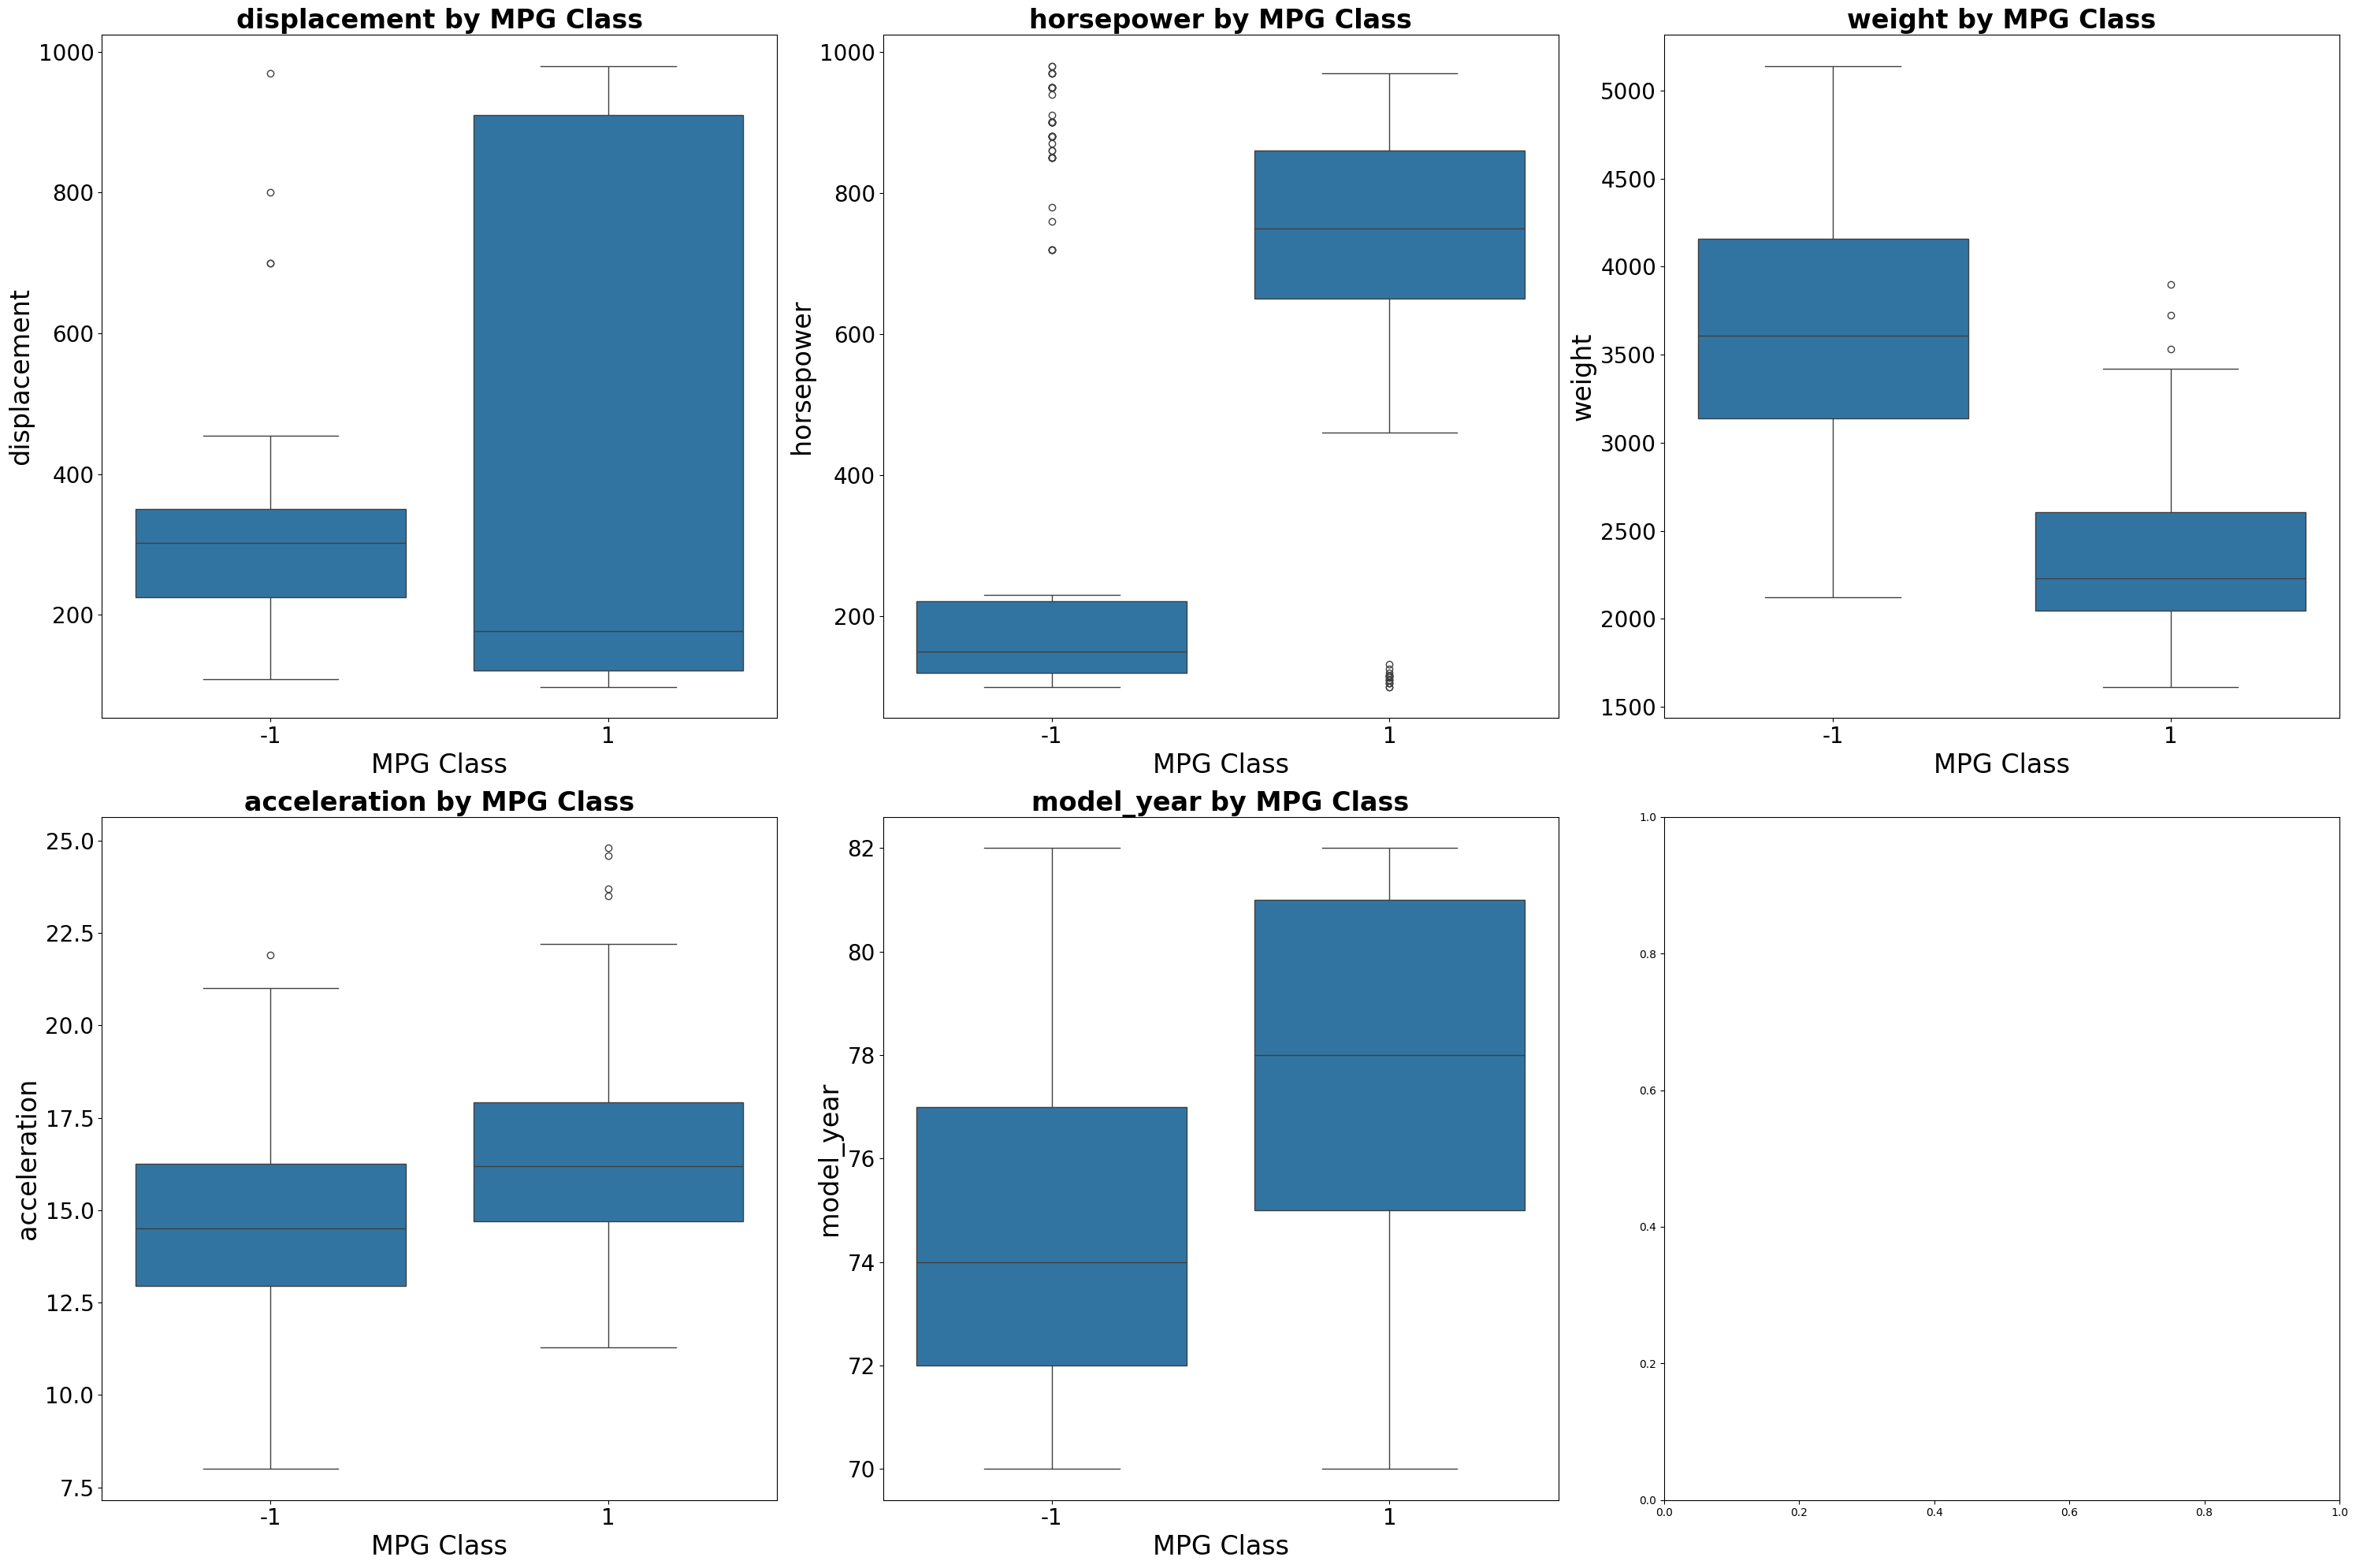

In [65]:
omitted_features = ['mpg','cylinders', 'car_name', 'car_make', 'origin']
features = [col for col in df.columns if col not in omitted_features]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))

for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x='mpg', y=feature, data=df, ax=ax)
    ax.set_title(f'{feature} by MPG Class', fontsize='24', fontweight='bold')
    ax.set_xlabel('MPG Class', fontsize='24')
    ax.set_ylabel(feature, fontsize='24')
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()

Backed by previous histograms, we observe the strongest correlations with horsepower and weight. Model year, despite having overlap in the IQR, has a clear difference in medians and may be useful when used in combination with the other features. The same can be said for acceleration, which exhibits a faint trend. 

Text(0.5, 1.0, 'Correlation Matrix')

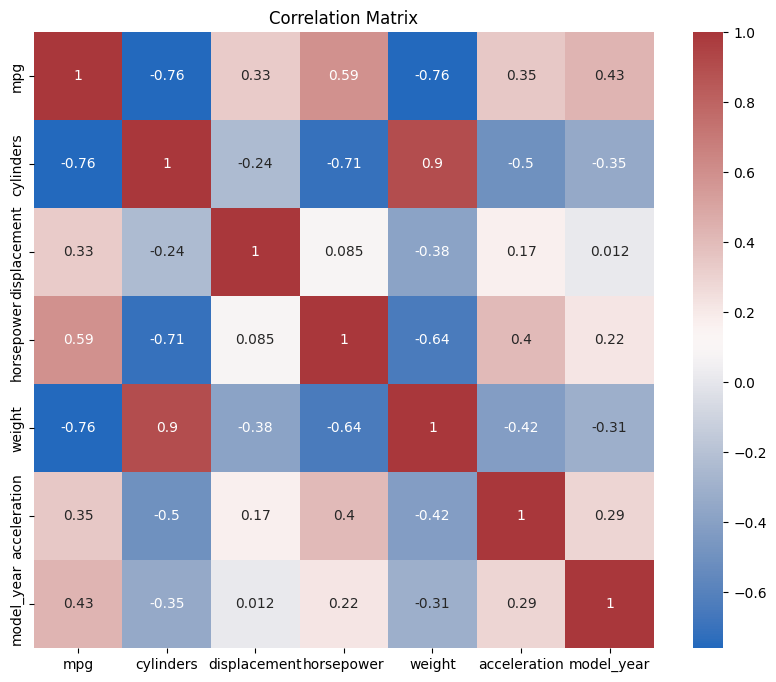

In [79]:
omitted_features = ['car_name', 'car_make', 'origin']
features = [col for col in df.columns if col not in omitted_features]
correlation = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='vlag')
plt.title("Correlation Matrix")

Most importantly, from this matrix we see that weight and cylinder count have a very strong correlation (0.9), so it may be worth removing one of the two features in the future as they provide very similar information to the linear model (multicollinearity).